In [176]:
%matplotlib inline
import matplotlib as mlp
mlp.rcParams['figure.dpi'] = 150

# diasbling warning messages
import warnings
warnings.filterwarnings("ignore")

# notebook dependencies
import pandas as pd
# pd.set_option('display.max_rows', None, 'display.max_columns', None)
import numpy as np

#visualizations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "darkgrid")

# math modules
from math import sqrt
import scipy.stats as stats

import acquire
import prepare

# sklearn data science library
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.metrics import mean_squared_error
from sklearn.impute import IterativeImputer
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.decomposition import PCA 
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [177]:
# import the data

df = acquire.get_bach_df()
df = prepare.clean_college_df(df)

# merge and transform for target variable
new_df = prepare.avg_net_price(df)
new_df['major_category'] = new_df.major_name.apply(prepare.categorize_major)

# Ensure you have `2017_2018_2019_earning_by_major.csv` within working folder
new_df = prepare.earnings_merge(new_df)
new_df = prepare.roi_5yr(new_df)
new_df = prepare.roi_10yr(new_df)

new_df.head()

dataframe shape: (71901, 125)


,unit_id_institution,college_name,institution_control,city,state_post_code,zip_code,share_entering_students_first_ft,share_of_part_time,pred_degree,region_ipeds,...,fedral_loan_full_time_first_time_undergraduate,pell_grant_full_time_first_time_undergraduate,avg_net_price,major_category,2017,2018,2019,Grand Total,roi_5yr,roi_10yr
0,100654.0,Alabama A & M University,Public,Normal,AL,35762,0.8987,0.0587,3.0,5.0,...,0.7143,0.7057,14444.0,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,-65075.748698,78598.877181
1,100654.0,Alabama A & M University,Public,Normal,AL,35762,0.8987,0.0587,3.0,5.0,...,0.7143,0.7057,14444.0,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,-65075.748698,78598.877181
2,100858.0,Auburn University,Public,Auburn,AL,36849,0.7973,0.0791,3.0,5.0,...,0.3039,0.1409,23696.0,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,-74327.748698,69346.877181
3,100858.0,Auburn University,Public,Auburn,AL,36849,0.7973,0.0791,3.0,5.0,...,0.3039,0.1409,23696.0,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,-74327.748698,69346.877181
4,101541.0,Judson College,"Private, nonprofit",Marion,AL,36756,0.7209,0.1622,3.0,5.0,...,0.7385,0.6000,16619.0,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,-67250.748698,76423.877181


In [178]:
# generate a new df for variables i'll be studying

df = new_df[[ 
"college_name",
"institution_control",
"zip_code",
"share_entering_students_first_ft",
"share_of_part_time",
"required_score",
"major_name",
"online_only",
"graduate_number",
"title_IV_student_number",
'other_fam_income_0_30000',
'private_fam_income_0_30000',
'program_fam_income_0_30000',
'pub_fam_income_0_30000',
'other_fam_income_30001_48000',
'private_fam_income_30001_48000',
'program_fam_income_30001_48000',
'pub_fam_income_30001_48000',
'other_fam_income_48001_75000',
'private_fam_income_48001_75000',
'program_fam_income_48001_75000',
'pub_fam_income_48001_75000',
'other_fam_income_75001_110000',
'private_fam_income_75001_110000',
'program_fam_income_75001_110000',
'pub_fam_income_75001_110000',
'other_fam_income_over_110000',
'private_fam_income_over_110000',
'program_fam_income_over_110000',
'pub_fam_income_over_110000',
"deg_percent_awarded_agriculture_operations",
"deg_percent_awarded_natural_resources",
"deg_percent_awarded_architecture",
"deg_percent_awarded_area_ethnic_cultural_gender",
"deg_percent_awarded_communication_journalism",
"deg_percent_awarded_communication_tech",
"deg_percent_awarded_computer_science",
"deg_percent_awarded_personal_culinary_services",
"deg_percent_awarded_education",
"deg_percent_awarded_engineering",
"deg_percent_awarded_engineering_tech",
"deg_percent_awarded_foreign_language_literatures",
"deg_percent_awarded_human_science",
"deg_percent_awarded_legal_profession",
"deg_percent_awarded_english_lang",
"deg_percent_awarded_general_studies",
"deg_percent_awarded_library_sciences",
"deg_percent_awarded_bio_sciences",
"deg_percent_awarded_mathematics_and_stats",
"deg_percent_awarded_military_tech",
"deg_percent_awarded_intedisciplinary_studies",
"deg_percent_awarded_leisure_fitness",
"deg_percent_awarded_philosophy",
"deg_percent_awarded_theology",
"deg_percent_awarded_physical_sciences",
"deg_percent_awarded_science_tech",
"deg_percent_awarded_psychology",
"deg_percent_awarded_homeland_security",
"deg_percent_awarded_public_admin",
"deg_percent_awarded_social_sciences",
"deg_percent_awarded_construction_trades",
"deg_percent_awarded_mechanic_repair",
"deg_percent_awarded_precision_production",
"deg_percent_awarded_transportation_materials",
"deg_percent_awarded_visual_and_performing_arts",
"deg_percent_awarded_health",
"deg_percent_awarded_business_management",
"deg_percent_awarded_history",
"comp_rt_ft_150over_expected_time_two_races",
"comp_rt_ft_150over_expected_time_native_american",
"comp_rt_ft_150over_expected_time_asian",
"comp_rt_ft_150over_expected_time_black",
"comp_rt_ft_150over_expected_time_hispanic",
"comp_rt_ft_150over_expected_time_non_resident",
"comp_rt_ft_150over_expected_time_unknown_race",
"comp_rt_ft_150over_expected_time_white",
"comp_rt_ft_150over_expected_time",
"enrollment_share_two_races",
"enrollment_share_native_american",
"enrollment_share_asian",
"enrollment_share_black",
"enrollment_share_hispanic",
"enrollment_share_pac_islander",
"enrollment_share_non_resident",
"enrollment_share_unknown",
"enrollment_share_white",
"fedral_loan_full_time_first_time_undergraduate",
"pell_grant_full_time_first_time_undergraduate",
'major_category',
'2017',
'2018',
'2019',
'Grand Total',
'avg_net_price',
'roi_5yr',
'roi_10yr'
]]

# print the shape
df.shape

(71422, 96)

In [179]:
# view the head

df.head()

,college_name,institution_control,zip_code,share_entering_students_first_ft,share_of_part_time,required_score,major_name,online_only,graduate_number,title_IV_student_number,...,fedral_loan_full_time_first_time_undergraduate,pell_grant_full_time_first_time_undergraduate,major_category,2017,2018,2019,Grand Total,avg_net_price,roi_5yr,roi_10yr
0,Alabama A & M University,Public,35762,0.8987,0.0587,1.0,"Agriculture, General.",0.0,963.0,NaN,...,0.7143,0.7057,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,14444.0,-65075.748698,78598.877181
1,Alabama A & M University,Public,35762,0.8987,0.0587,1.0,"Agriculture, Agriculture Operations, and Relat...",0.0,963.0,NaN,...,0.7143,0.7057,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,14444.0,-65075.748698,78598.877181
2,Auburn University,Public,36849,0.7973,0.0791,1.0,"Agriculture, General.",0.0,5812.0,NaN,...,0.3039,0.1409,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,23696.0,-74327.748698,69346.877181
3,Auburn University,Public,36849,0.7973,0.0791,1.0,Agricultural Production Operations.,0.0,5812.0,NaN,...,0.3039,0.1409,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,23696.0,-74327.748698,69346.877181
4,Judson College,"Private, nonprofit",36756,0.7209,0.1622,1.0,Agricultural and Domestic Animal Services.,0.0,NaN,58.0,...,0.7385,0.6000,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,16619.0,-67250.748698,76423.877181


In [180]:
# variables needed for socioeconomic study

# lst = pd.Series(['other_fam_income_0_30000', 'private_fam_income_0_30000', 'program_fam_income_0_30000', 'pub_fam_income_0_30000', 'other_fam_income_30001_48000', 'private_fam_income_30001_48000', 'program_fam_income_30001_48000', 'pub_fam_income_30001_48000', 'other_fam_income_48001_75000', 'private_fam_income_48001_75000', 'program_fam_income_48001_75000', 'pub_fam_income_48001_75000', 'other_fam_income_75001_110000', 'private_fam_income_75001_110000', 'program_fam_income_75001_110000', 'pub_fam_income_75001_110000', 'other_fam_income_over_110000', 'private_fam_income_over_110000', 'program_fam_income_over_110000', 'pub_fam_income_over_110000'])
# lst.tolist()

In [181]:
# collapse avg net price to one column

def avg_net_price(df):

    '''Function that creates a new 'average net price' column from 
    existing avg net public and private columns.
    
    This function takes in a dataframe and re-labels null values as 0 in order
    to add across the two avg net price observations.'''

    df['avg_net_price_public'] = df['avg_net_price_public'].fillna(0)

    df['avg_net_price_private'] = df['avg_net_price_private'].fillna(0)

    df['avg_net_price'] = df.avg_net_price_public + df.avg_net_price_private

    # return the dataframe
    return df

In [182]:
# income brackets

income_0_30000 = [
'other_fam_income_0_30000',
 'private_fam_income_0_30000',
 'program_fam_income_0_30000',
 'pub_fam_income_0_30000']

income_30001_48000 = [
 'other_fam_income_30001_48000',
 'private_fam_income_30001_48000',
 'program_fam_income_30001_48000',
 'pub_fam_income_30001_48000']

income_48001_75000 = [
'other_fam_income_48001_75000',
'private_fam_income_48001_75000',
'program_fam_income_48001_75000',
'pub_fam_income_48001_75000']

income_75001_110000 = [
'other_fam_income_75001_110000',
'private_fam_income_75001_110000',
'program_fam_income_75001_110000',
'pub_fam_income_75001_110000']

income_over_110000 = [
'other_fam_income_over_110000',
'private_fam_income_over_110000',
'program_fam_income_over_110000',
'pub_fam_income_over_110000']

In [183]:
# used as reference

def get_fam_income_col(df, s1, s2, s3, s4):

    '''Function that creates a new 'average net price' column from 
    existing avg net public and private columns.
    
    This function takes in a dataframe and re-labels null values as 0 in order
    to add across the two avg net price observations.'''

    df[s1] = df[s1].fillna(0)

    df[s2] = df[s2].fillna(0)

    df[s3] = df[s3].fillna(0)

    df[s4] = df[s4].fillna(0)

    df['family_income_0_30000'] = df[s1] + df[s2] + df[s3] + df[s4]

    # drop redundant columns
    df = df.drop(columns = [s1, s2, s3, s4])

    # return the dataframe
    return df

In [184]:
# create a "collapse" cols function

def get_fam_income_col(df, col_lst, new_col_string):

    '''Function that creates a new family income columns from 
    existing dummy columns.'''

    df[col_lst] = df[col_lst].fillna(0)

    df[new_col_string] = df[col_lst].sum(axis = 1)

    # drop redundant columns
    df = df.drop(df[col_lst], axis = 1)

    # return the dataframe
    return df

In [185]:
df.shape

(71422, 96)

In [186]:
# splitting the dataset

s1 = 'other_fam_income_0_30000'
s2 = 'private_fam_income_0_30000'
s3 = 'program_fam_income_0_30000'
s4 = 'pub_fam_income_0_30000'

df = get_fam_income_col(df, income_0_30000, "fam_income_0_30000")
df.head()

,college_name,institution_control,zip_code,share_entering_students_first_ft,share_of_part_time,required_score,major_name,online_only,graduate_number,title_IV_student_number,...,pell_grant_full_time_first_time_undergraduate,major_category,2017,2018,2019,Grand Total,avg_net_price,roi_5yr,roi_10yr,fam_income_0_30000
0,Alabama A & M University,Public,35762,0.8987,0.0587,1.0,"Agriculture, General.",0.0,963.0,NaN,...,0.7057,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,14444.0,-65075.748698,78598.877181,375.0
1,Alabama A & M University,Public,35762,0.8987,0.0587,1.0,"Agriculture, Agriculture Operations, and Relat...",0.0,963.0,NaN,...,0.7057,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,14444.0,-65075.748698,78598.877181,375.0
2,Auburn University,Public,36849,0.7973,0.0791,1.0,"Agriculture, General.",0.0,5812.0,NaN,...,0.1409,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,23696.0,-74327.748698,69346.877181,254.0
3,Auburn University,Public,36849,0.7973,0.0791,1.0,Agricultural Production Operations.,0.0,5812.0,NaN,...,0.1409,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,23696.0,-74327.748698,69346.877181,254.0
4,Judson College,"Private, nonprofit",36756,0.7209,0.1622,1.0,Agricultural and Domestic Animal Services.,0.0,NaN,58.0,...,0.6000,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,16619.0,-67250.748698,76423.877181,20.0


In [187]:
# check the shape

df.shape # checks out

(71422, 93)

In [188]:
# running function for remaining fam_income_variables

# list of cols to collapse
frames = [
    income_30001_48000, 
    income_48001_75000, 
    income_75001_110000, 
    income_over_110000]

# list of new col names
var_names = [
    'income_30001_48000', 
    'income_48001_75000', 
    'income_75001_110000', 
    'income_over_110000']

for i in range(len(frames)):
    var_name = var_names[i]
    df = get_fam_income_col(df, frames[i], var_name)

print(df.shape)
df.head()

(71422, 81)


,college_name,institution_control,zip_code,share_entering_students_first_ft,share_of_part_time,required_score,major_name,online_only,graduate_number,title_IV_student_number,...,2019,Grand Total,avg_net_price,roi_5yr,roi_10yr,fam_income_0_30000,income_30001_48000,income_48001_75000,income_75001_110000,income_over_110000
0,Alabama A & M University,Public,35762,0.8987,0.0587,1.0,"Agriculture, General.",0.0,963.0,NaN,...,61388.93381,174512.4921,14444.0,-65075.748698,78598.877181,375.0,113.0,61.0,27.0,16.0
1,Alabama A & M University,Public,35762,0.8987,0.0587,1.0,"Agriculture, Agriculture Operations, and Relat...",0.0,963.0,NaN,...,61388.93381,174512.4921,14444.0,-65075.748698,78598.877181,375.0,113.0,61.0,27.0,16.0
2,Auburn University,Public,36849,0.7973,0.0791,1.0,"Agriculture, General.",0.0,5812.0,NaN,...,61388.93381,174512.4921,23696.0,-74327.748698,69346.877181,254.0,155.0,166.0,201.0,364.0
3,Auburn University,Public,36849,0.7973,0.0791,1.0,Agricultural Production Operations.,0.0,5812.0,NaN,...,61388.93381,174512.4921,23696.0,-74327.748698,69346.877181,254.0,155.0,166.0,201.0,364.0
4,Judson College,"Private, nonprofit",36756,0.7209,0.1622,1.0,Agricultural and Domestic Animal Services.,0.0,NaN,58.0,...,61388.93381,174512.4921,16619.0,-67250.748698,76423.877181,20.0,10.0,10.0,10.0,8.0


In [189]:
# checking percentage of nulls across features
null_percentages = df.isnull().mean().round(2)

with pd.option_context('display.max_rows', None):
    print(null_percentages)

college_name                                        0.00
institution_control                                 0.00
zip_code                                            0.04
share_entering_students_first_ft                    0.06
share_of_part_time                                  0.04
required_score                                      0.14
major_name                                          0.00
online_only                                         0.04
graduate_number                                     0.17
title_IV_student_number                             0.47
deg_percent_awarded_agriculture_operations          0.04
deg_percent_awarded_natural_resources               0.04
deg_percent_awarded_architecture                    0.04
deg_percent_awarded_area_ethnic_cultural_gender     0.04
deg_percent_awarded_communication_journalism        0.04
deg_percent_awarded_communication_tech              0.04
deg_percent_awarded_computer_science                0.04
deg_percent_awarded_personal_cu

In [190]:
 # create list to collapse by genre
 
# deg_lst = list(null_percentages.iloc[null_percentages.index.str.startswith("deg_percent_awarded_")].index)

In [191]:
# check the shape

df.shape

(71422, 81)

In [192]:
# dropping title_IV_student_number which has a significantly high percentage of missing values/records

df = df.drop(columns = "title_IV_student_number")
df.shape

(71422, 80)

In [193]:
# split the data function

def split_data(df):
    
    train_and_validate, test = train_test_split(
                                                df, 
                                                test_size = 0.2, 
                                                random_state = 123,
                                                stratify = df["major_category"])

    train, validate = train_test_split(
                                    train_and_validate,
                                    test_size = 0.3,
                                    random_state = 123,
                                    stratify = train_and_validate["major_category"])

    print(f'train shape: {train.shape}')
    print(f'validate shape: {validate.shape}')
    print(f'test shape: {test.shape}')

    return train, validate, test

In [194]:
# splitting the data

train, validate, test = split_data(df)

train shape: (39995, 80)
validate shape: (17142, 80)
test shape: (14285, 80)


In [195]:
# recheck nulls

null_percentages = train.isnull().mean().round(2)

with pd.option_context('display.max_rows', None):
    print(null_percentages)# identify columns with > 10% missing records

college_name                                        0.00
institution_control                                 0.00
zip_code                                            0.04
share_entering_students_first_ft                    0.06
share_of_part_time                                  0.04
required_score                                      0.14
major_name                                          0.00
online_only                                         0.04
graduate_number                                     0.17
deg_percent_awarded_agriculture_operations          0.04
deg_percent_awarded_natural_resources               0.04
deg_percent_awarded_architecture                    0.04
deg_percent_awarded_area_ethnic_cultural_gender     0.04
deg_percent_awarded_communication_journalism        0.04
deg_percent_awarded_communication_tech              0.04
deg_percent_awarded_computer_science                0.04
deg_percent_awarded_personal_culinary_services      0.04
deg_percent_awarded_education  

In [196]:
# identify features with greater than 10% missing records

container = []

for i in range(len(null_percentages.values)):
    if null_percentages[i] > .1:

        container.append(null_percentages.index[i])

container

['required_score',
 'graduate_number',
 'comp_rt_ft_150over_expected_time_two_races',
 'comp_rt_ft_150over_expected_time_native_american',
 'comp_rt_ft_150over_expected_time_asian',
 'comp_rt_ft_150over_expected_time_non_resident',
 'comp_rt_ft_150over_expected_time_unknown_race']

In [197]:
# check percentage of nulls for numerical columns

check_nulls = train[train.select_dtypes(include = "number").columns]

In [198]:
# retrieving numerical column lower/upper bound outliers
# with pd.option_context('display.max_rows', None):

pd.set_option('display.max_rows', None)

def get_outliers_table(df, k = 1.5):
    '''Function to loop through dataframe and return
    continuous variable outliers outside of Q1 and Q3 using of an IQR method.'''

    l1 = df.select_dtypes(include = "number").columns.tolist()

     # dont learn from these variables
    target_lst = [ 
                "roi_5yr",
                "roi_10yr",
                "2017",                                               
                "2018",                                                   
                "2019",
                "Grand Total",
                "avg_net_price"
        ]
    
    # include non-target 
    num_lst = [col for col in l1 if col not in target_lst]

    holder = []

    # determining continuous features/columns
    for col in train[num_lst]:
        
        # determing 1st and 3rd quartile
        q1, q3 = train[col].quantile([.25, 0.75])
        
        # calculate interquartile range
        iqr = q3 - q1
        
        # set feature/data lower bound limit
        lower_bound = q1 - k * iqr

        # set feature/data upperbound limit
        upper_bound = q3 + k * iqr
        
        metrics = { 
            
            "column": col,
            "column type": train[col].dtype,
            "iqr": round(iqr, 5),
            "lower_bound": round(lower_bound, 5),
            "lower_outliers": len(train[train[col] < lower_bound]),
            "upper_bound": round(upper_bound, 5),
            "upper_outliers": len(train[train[col] > upper_bound])
        }

        holder.append(metrics)

    num_outliers = pd.DataFrame(holder)
    num_outliers = num_outliers.sort_values(by = [ "upper_outliers", "lower_outliers"], ascending = False)

    return num_outliers

num_outliers = get_outliers_table(train)

In [199]:
ls1 = num_outliers[(num_outliers["lower_outliers"] == 0) & (num_outliers["upper_outliers"] == 0)].index
ls2 = num_outliers[(num_outliers["lower_bound"] == 0) & (num_outliers["upper_bound"] == 0)].index
ls3 = num_outliers[(num_outliers["lower_bound"] == 1) & (num_outliers["upper_bound"] == 1)].index


num_outliers = num_outliers.drop(ls1)
num_outliers = num_outliers.drop(ls2)
num_outliers = num_outliers.drop(ls3)
num_outliers

,column,column type,iqr,lower_bound,lower_outliers,upper_bound,upper_outliers
15,deg_percent_awarded_engineering_tech,float64,0.00110,-0.00165,0,0.00275,9086
17,deg_percent_awarded_human_science,float64,0.00690,-0.01035,0,0.01725,6988
8,deg_percent_awarded_area_ethnic_cultural_gender,float64,0.00320,-0.00480,0,0.00800,4785
20,deg_percent_awarded_general_studies,float64,0.03850,-0.05775,0,0.09625,3964
54,enrollment_share_asian,float64,0.04610,-0.05725,0,0.12715,3905
57,enrollment_share_pac_islander,float64,0.00180,-0.00220,0,0.00500,3803
53,enrollment_share_native_american,float64,0.00390,-0.00445,0,0.01115,3799
55,enrollment_share_black,float64,0.09450,-0.10165,0,0.27635,3563
56,enrollment_share_hispanic,float64,0.10320,-0.10800,0,0.30480,3504
25,deg_percent_awarded_intedisciplinary_studies,float64,0.02580,-0.03870,0,0.06450,3440


In [200]:
from scipy.stats.mstats import winsorize

def percentile_capping(df, low_end, high_end):
    '''Function that uses scipy's winsorize method to cap
    continuous variables at lower and higher end based on a passed 
    percentile values.'''

    l1 = df.select_dtypes(include = "number").columns.tolist()

    # dont include target variables to cap
    target_lst = [ 
                "roi_5yr",
                "roi_10yr",
                "2017",                                               
                "2018",                                                   
                "2019",
                "Grand Total",
                "avg_net_price"]

    col_lst = [col for col in l1 if col not in target_lst]

    for col in col_lst:

        stats.mstats.winsorize(
            a = df[col], 
            limits = (low_end, high_end), 
            inplace = True)

In [204]:
# test out the function

percentile_capping(train, 0.1, 0.1)
num_outliers = get_outliers_table(train)

In [226]:
# inspect the functions worked
target_lst = [ 
                "roi_5yr",
                "roi_10yr",
                "2017",                                               
                "2018",                                                   
                "2019",
                "Grand Total",
                "avg_net_price"]

num_outiers = [col for col in num_outliers if col not in target_lst]

ls1 = num_outliers[(num_outliers["lower_outliers"] == 0) & (num_outliers["upper_outliers"] == 0)].index
ls2 = num_outliers[(num_outliers["lower_bound"] == 0) & (num_outliers["upper_bound"] == 0)].index
ls3 = num_outliers[(num_outliers["lower_bound"] == 1) & (num_outliers["upper_bound"] == 1)].index


num_outliers = num_outliers.drop(ls1)
num_outliers = num_outliers.drop(ls2)
num_outliers = num_outliers.drop(ls3)

num_outliers

,column,column type,iqr,lower_bound,lower_outliers,upper_bound,upper_outliers
15,deg_percent_awarded_engineering_tech,float64,0.00520,-0.00780,0,0.01300,8254
17,deg_percent_awarded_human_science,float64,0.01190,-0.01785,0,0.02975,6527
8,deg_percent_awarded_area_ethnic_cultural_gender,float64,0.00410,-0.00615,0,0.01025,5560
57,enrollment_share_pac_islander,float64,0.00210,-0.00265,0,0.00575,4910
53,enrollment_share_native_american,float64,0.00430,-0.00495,0,0.01225,4832
54,enrollment_share_asian,float64,0.05440,-0.06920,0,0.14840,4745
20,deg_percent_awarded_general_studies,float64,0.04770,-0.07155,0,0.11925,4540
56,enrollment_share_hispanic,float64,0.11930,-0.13085,0,0.34635,4404
55,enrollment_share_black,float64,0.11225,-0.12732,0,0.32167,4363
59,enrollment_share_unknown,float64,0.03980,-0.04950,0,0.10970,4335


In [208]:
# capping outliers

def handle_outliers(df, k = 1.5):
    '''Function determines outliers based on "iqr" and then handles outliers
    by transforming these observations to the mean.'''

    l1 = df.select_dtypes(include = "number").columns.tolist()

     # dont learn from these variables
    target_lst = [ 
                "roi_5yr",
                "roi_10yr",
                "2017",                                               
                "2018",                                                   
                "2019",
                "Grand Total",
                "avg_net_price"
        ]
    
    # include non-target 
    num_lst = [col for col in l1 if col not in target_lst]

    # determining continuous features/columns
    for col in df[num_lst]:
        
        # determing 1st and 3rd quartile
        q1, q3 = df[col].quantile([.25, 0.75])
        
        # calculate interquartile range
        iqr = q3 - q1
        
        # set feature/data lower bound limit
        lower_bound = q1 - k * iqr

        # set feature/data upperbound limit
        upper_bound = q3 + k * iqr
        
        # avg value
        avg_value = df[col].mean()

        # cap/convert outliers to upperbound
        df[col] = df[col].apply(lambda x: avg_value if x < lower_bound else x)

        # cap/convert outliers to upperbound
        df[col] = df[col].apply(lambda x: avg_value if x > upper_bound else x)
    
        # renaming the column to reflect capping
        # df.rename(columns = {col: col + "_transformed"}, inplace = True)

    # returning the updated dataframe
    return df

In [ ]:
# capping records at lower and upper bounds
# train = handle_outliers(train)
# num_outliers = get_outliers_table(train)

# # inspect the functions worked
# num_outliers

In [209]:
# capping validate and test dfs

percentile_capping(validate, 0.1, 0.1)
percentile_capping(test, 0.1, 0.1)

In [227]:
# create the imputer

def train_iterative_imputer(train_df):

        # placeholder for continuous features
        l1 = train_df.select_dtypes(include = "number").columns.tolist()

        # dont learn from these variables
        target_lst = [ 
                "roi_5yr",
                "roi_10yr",
                "2017",                                               
                "2018",                                                   
                "2019",
                "Grand Total",
                "avg_net_price"
        ]
        
        num_lst = [col for col in l1 if col not in target_lst]
        
        # creating the "thing"
        imputer = IterativeImputer(
                missing_values = np.nan, \
                skip_complete = True, \
                random_state = 123)
        
        # fitting the "thing" and transforming it
        imputed = imputer.fit_transform(train_df[num_lst])

           # create a new dataframe with learned imputed data
        train_df_imputed = pd.DataFrame(imputed, index = train_df.index)

        # filling in missing values from learned imputer
        train_df[num_lst] = train_df_imputed

        # return the new imputed df
        return train_df

In [ ]:
# handling remaining null values using sklearn's iterative imputer

train_imputed = train_iterative_imputer(train)

# retuning remaining nulls
remaining_nulls = train_imputed.isnull().sum()

with pd.option_context('display.max_rows', None):
    print(remaining_nulls) # zip codes still missing

college_name                                           0
institution_control                                    0
zip_code                                            1642
share_entering_students_first_ft                       0
share_of_part_time                                     0
required_score                                         0
major_name                                             0
online_only                                            0
graduate_number                                        0
deg_percent_awarded_agriculture_operations             0
deg_percent_awarded_natural_resources                  0
deg_percent_awarded_architecture                       0
deg_percent_awarded_area_ethnic_cultural_gender        0
deg_percent_awarded_communication_journalism           0
deg_percent_awarded_communication_tech                 0
deg_percent_awarded_computer_science                   0
deg_percent_awarded_personal_culinary_services         0
deg_percent_awarded_education  

In [211]:
# impute zip codes by mode

train_imputed["zip_code"] = train_imputed["zip_code"].fillna(train_imputed["zip_code"].mode()[0])
print(f'zip_code missing values: {train_imputed.zip_code.isnull().sum()}') # checks out

zip_code missing values: 0


In [ ]:
# shape
train_imputed.shape

(39995, 80)

In [212]:
# can do the same across validate and test datasets

def impute_val_and_test(train_df, val_df, test_df):
        
        '''Function takes in all three split datasets and imputes missing values in validate and test after
        fitting on training dataset columns'''

        l1 = train_df.select_dtypes(include = "number").columns.tolist()

        target_lst = [ 
        "roi_5yr",
        "roi_10yr",
        "2017",                                               
        "2018",                                                   
        "2019",
        "Grand Total",
        "avg_net_price"
        ]

        # recheck cols are not in target list
        num_lst = [col for col in l1 if col not in target_lst]

        # creating the sklearn imputer
        imputer = IterativeImputer(
                missing_values = np.nan, \
                skip_complete = True, \
                random_state = 123)

        # fitting the imputer
        imputed = imputer.fit(train_df[num_lst])

        # transforming values
        val_imputed = imputed.transform(val_df[num_lst])
        X_validate_imputed = pd.DataFrame(val_imputed, index = val_df.index)
        val_df[num_lst] = X_validate_imputed
        validate_imputed = val_df

        test_imputed = imputed.transform(test_df[num_lst])
        test_imputed = pd.DataFrame(test_imputed, index = test_df.index)
        test_df[num_lst] = test_imputed
        test_imputed = test_df

        # fill-in any instances of missing zip-code values
        validate_imputed["zip_code"] = validate_imputed["zip_code"].fillna(validate_imputed["zip_code"].mode()[0])
        test_imputed["zip_code"] = test_imputed["zip_code"].fillna(test_imputed["zip_code"].mode()[0])


        # returning the imputed validate and test datasets
        return validate_imputed, test_imputed

In [213]:
# look at train

train.shape
train.head()

,college_name,institution_control,zip_code,share_entering_students_first_ft,share_of_part_time,required_score,major_name,online_only,graduate_number,deg_percent_awarded_agriculture_operations,...,2019,Grand Total,avg_net_price,roi_5yr,roi_10yr,fam_income_0_30000,income_30001_48000,income_48001_75000,income_75001_110000,income_over_110000
25530,University of Memphis,Public,38152,0.6227,0.2274,1.0,Journalism.,0.0,4225.0,0.0000,...,58348.57445,169831.2865,13048.0,-74625.310753,52258.720623,559.0,300.0,248.0,186.0,209.0
53875,Limestone University,"Private, nonprofit",29340-3799,0.5654,0.2116,1.0,Communication and Media Studies.,0.0,106.0,0.0000,...,66997.75002,191767.4743,24083.0,-45903.361529,128746.339159,106.0,51.0,57.0,39.0,49.0
42932,Texas State University,Public,78666,0.6166,0.1797,1.0,Design and Applied Arts.,0.0,4457.0,0.0122,...,53039.54507,152893.5207,14692.0,-104145.800598,-6581.250562,559.0,300.0,303.0,274.0,471.0
45495,Judson University,"Private, nonprofit",60123-1498,0.4673,0.3243,1.0,Accounting and Related Services.,0.0,222.0,0.0000,...,79608.39225,231146.3982,20498.0,23043.529582,267336.372751,28.0,16.0,37.0,29.0,28.0
25003,Yeshiva University,"Private, nonprofit",10033-3299,0.9601,0.0183,1.0,"Classics and Classical Languages, Literatures,...",0.0,3751.0,0.0000,...,58348.57445,169831.2865,29592.0,-97991.310753,28892.720623,58.0,26.0,34.0,34.0,97.0


In [214]:
# impute missing values in validate and test 

validate_imputed, test_imputed = impute_val_and_test(train, validate, test)
print(f'validate shape: {validate_imputed.shape}')
print(f'test shape: {test_imputed.shape}')

validate shape: (17142, 80)
test shape: (14285, 80)


----
### ``Target Variable Distribution``

5 YEAR ROI 

10 YEAR ROI

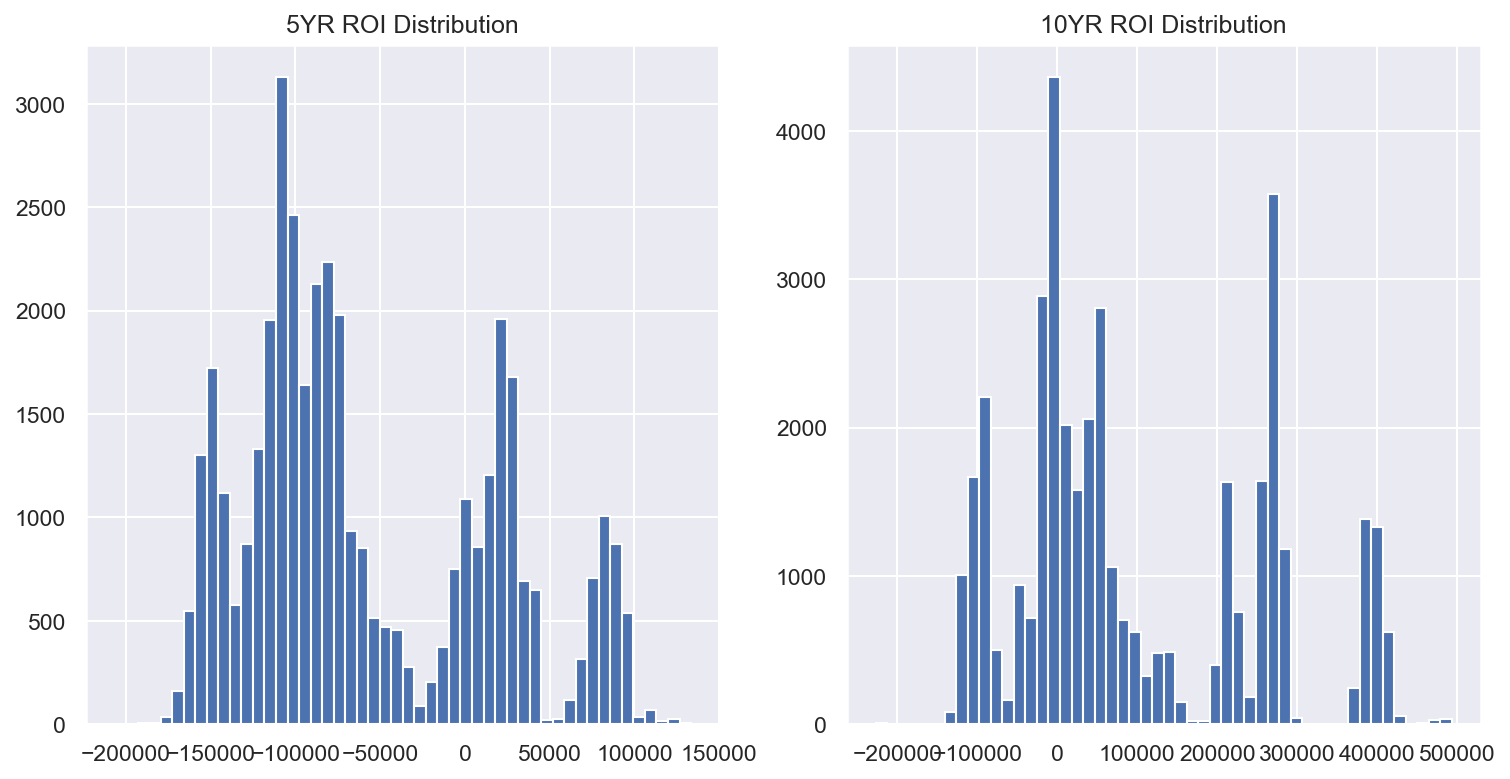

In [215]:
# side-by-side comparison

plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))

plt.subplot(121)
plt.title("5YR ROI Distribution")
plt.hist(train_imputed["roi_5yr"], bins = 50)

plt.subplot(122)
plt.title("10YR ROI Distribution")
plt.hist(train_imputed["roi_10yr"], bins = 50)

plt.show()

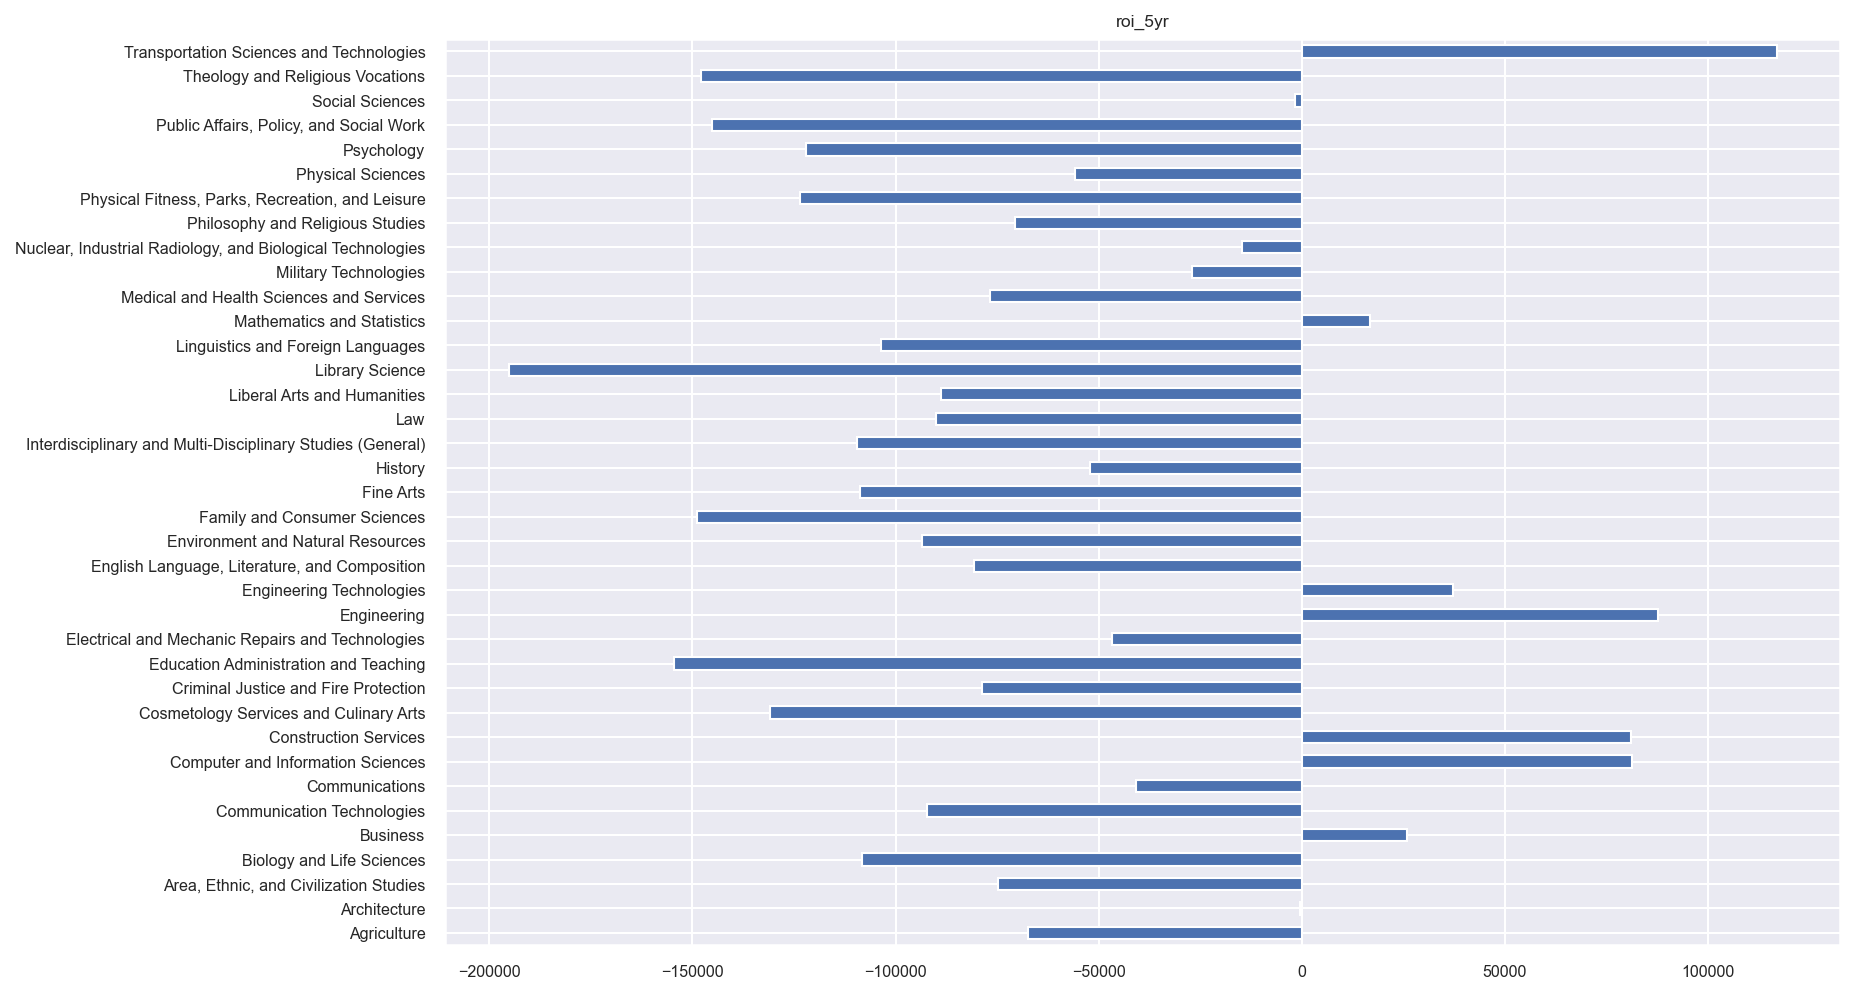

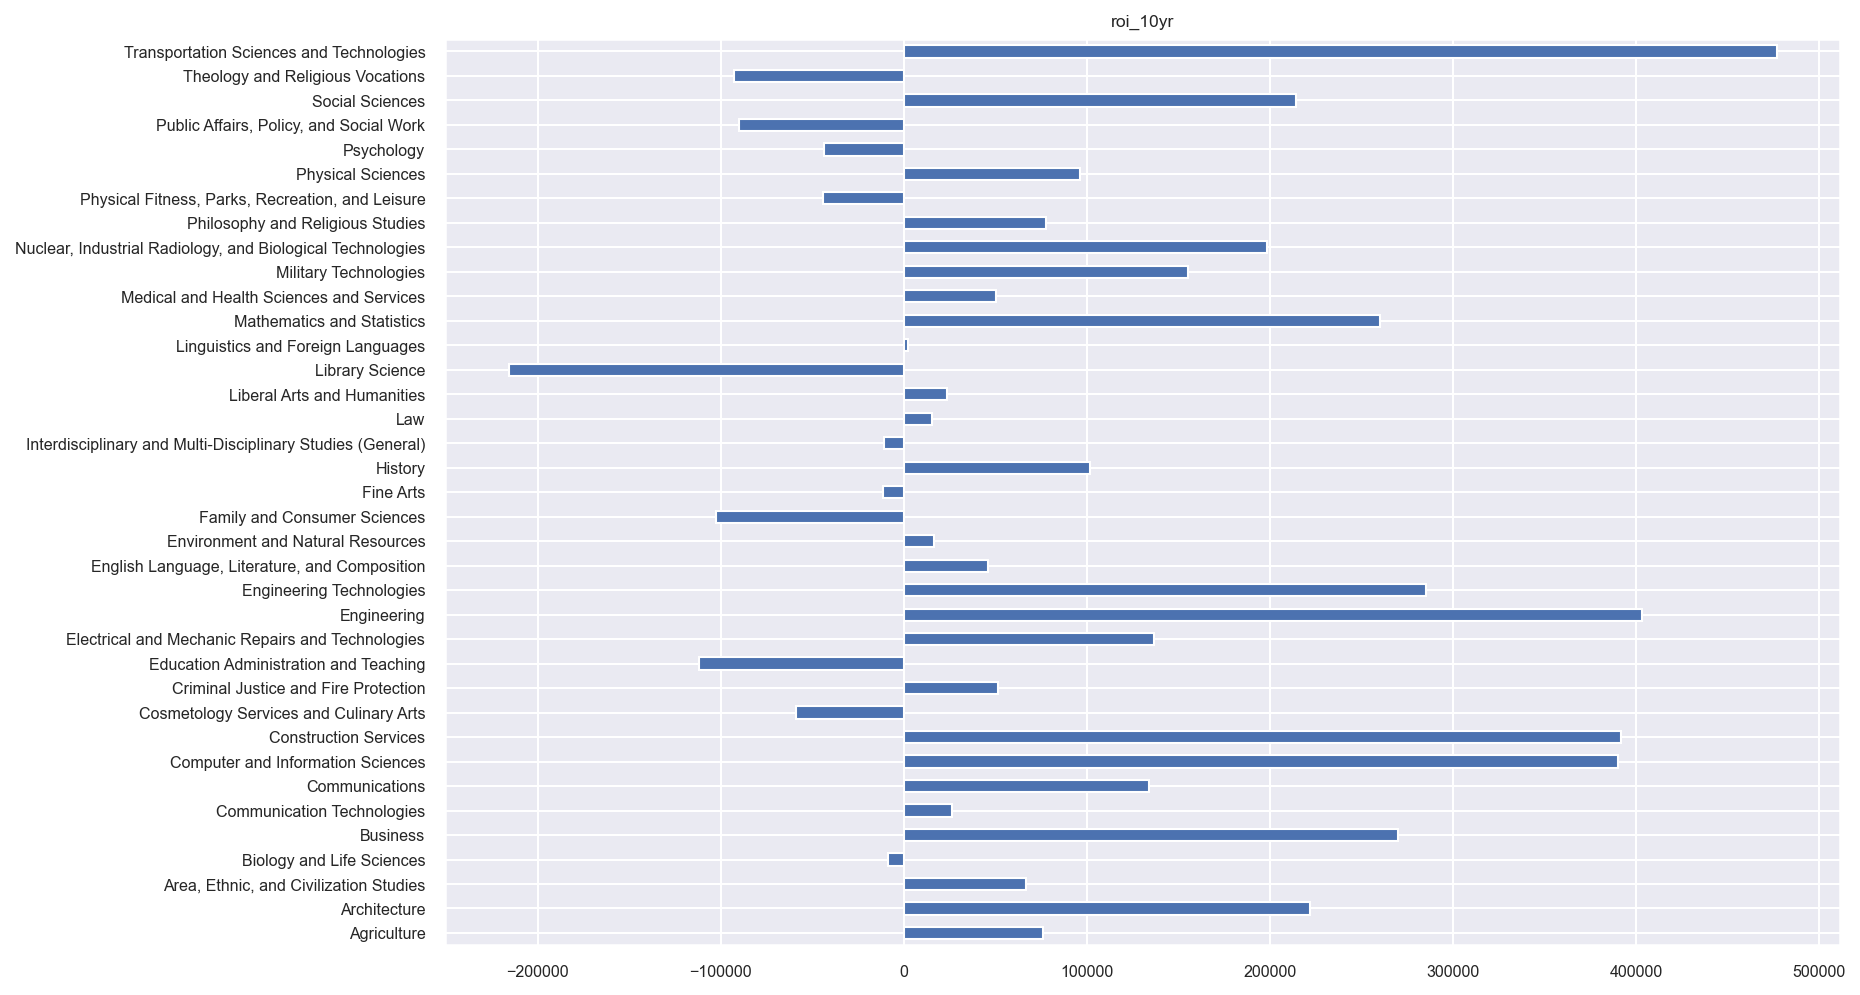

In [244]:
# are majors statistically significant in determining 5/10yr ROI
# let's plot major by their 5/10yr ROI Mean

roi_vars = ["roi_5yr", "roi_10yr"]

for i in range(len(roi_vars)):
    plt.figure(figsize = (12,8))

    train_imputed.groupby(
        ["major_category"])[roi_vars[i]].mean().plot(
                                                    kind = "barh")

    plt.ylabel(None)
    plt.title(roi_vars[i])
    plt.show()

``Hypothesis Question #1: ``

**Is there a difference in ROI earnings across majors?**

Null Hypothesis: "There's not a statistical 5-year Major ROI difference college majors."

Alternative Hypothesis: "There is a statistical 5-year Major ROI difference difference college majors."

----

Null Hypothesis: "There's not a statistical 10-year Major ROI difference college majors."

Alternative Hypothesis: "There is a statistical 10-year Major ROI difference difference college majors."


alpha: 0.05

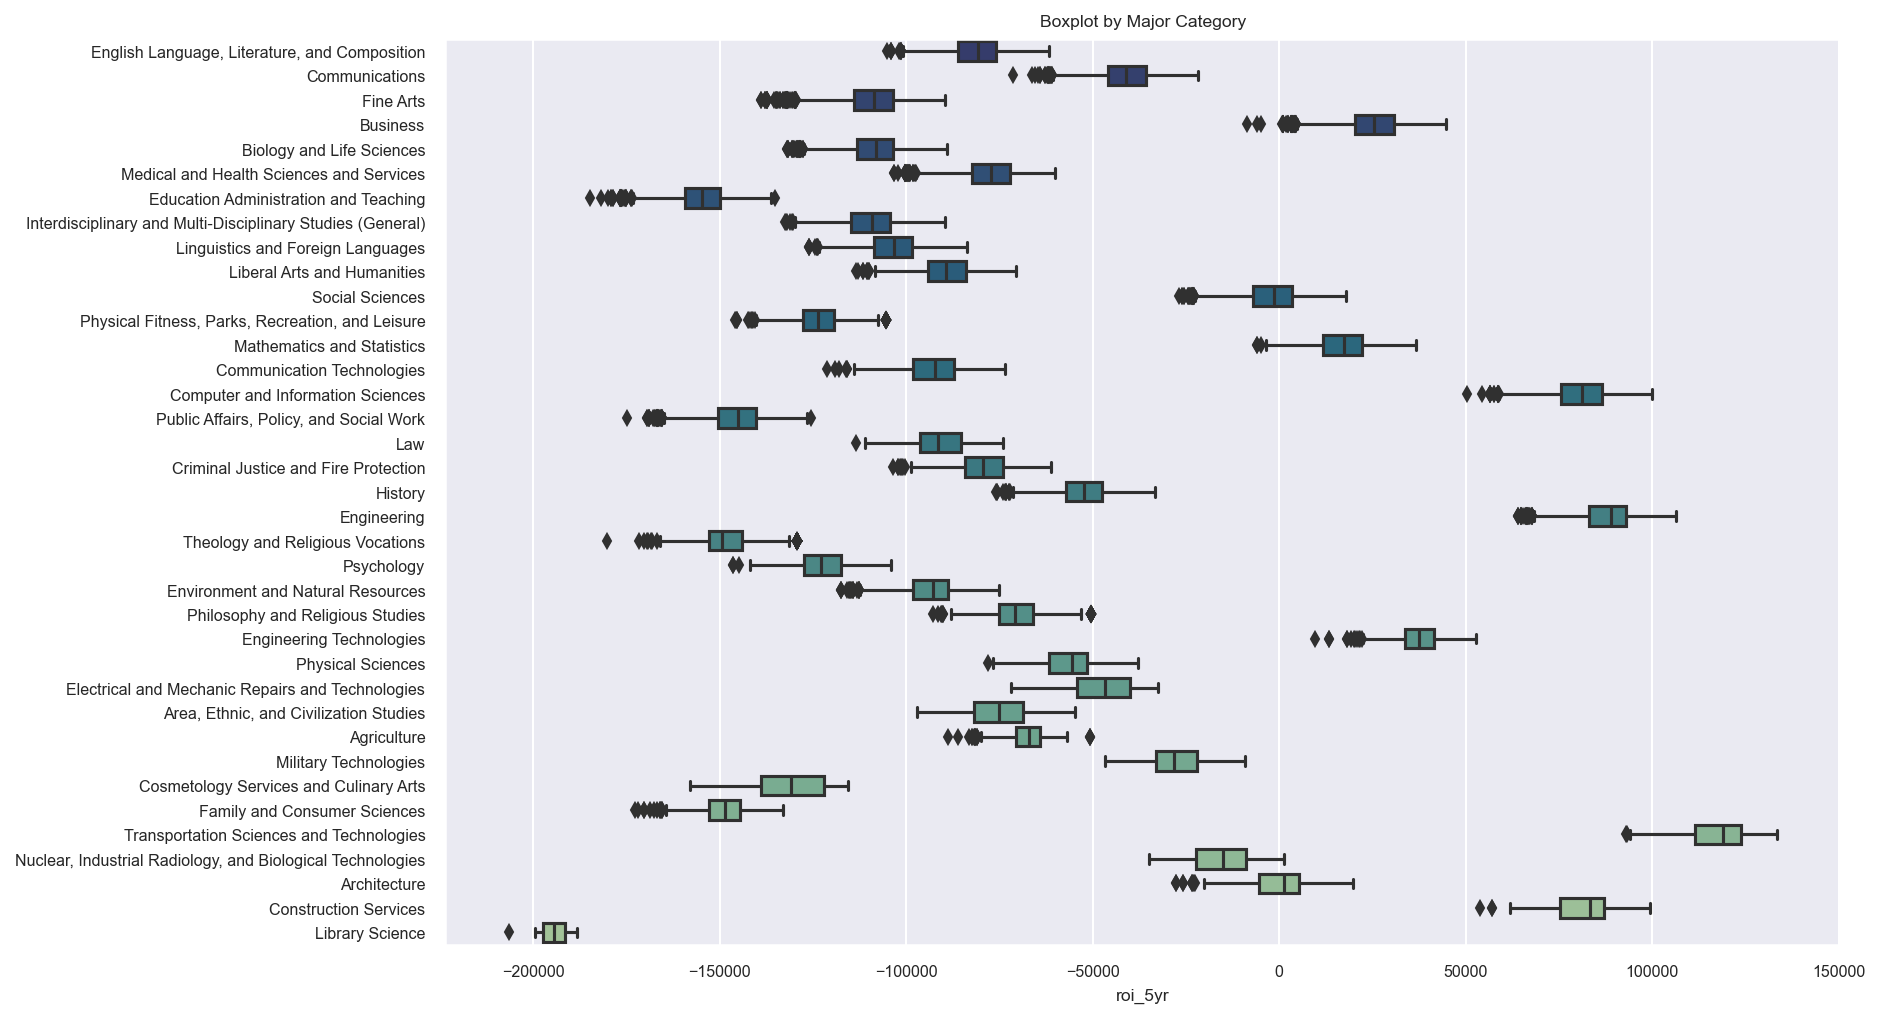

In [268]:
# bar plot?
plt.figure(figsize = (12, 8))

sns.boxplot(
    x = "roi_5yr",
    y = "major_category",
    data = train_imputed,
    orient = "h",
    palette = "crest_r"
)

plt.title("Boxplot by Major Category")
plt.ylabel(None)
plt.show()

In [ ]:
majors_lst = train_imputed["major_category"].unique().tolist()
text = "train_imputed[train_imputed[major_category] == "

container = []

for major in majors_lst:
    # concat/add major name to code string
    new_text = text + "'" + major + "'" + "]['roi_5yr'].values,"
    container.append(new_text)

# for ele in container:
#     print(ele)

In [287]:
# majors_lst = train_imputed["'major_category'"].unique().tolist()

f_statistic, p_value = stats.f_oneway(
                    train_imputed[train_imputed['major_category'] == 'English Language, Literature, and Composition']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Communications']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Fine Arts']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Business']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Biology and Life Sciences']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Medical and Health Sciences and Services']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Education Administration and Teaching']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Interdisciplinary and Multi-Disciplinary Studies (General)']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Linguistics and Foreign Languages']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Liberal Arts and Humanities']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Social Sciences']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Physical Fitness, Parks, Recreation, and Leisure']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Mathematics and Statistics']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Communication Technologies']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Computer and Information Sciences']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Public Affairs, Policy, and Social Work']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Law']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Criminal Justice and Fire Protection']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'History']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Engineering']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Theology and Religious Vocations']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Psychology']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Environment and Natural Resources']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Philosophy and Religious Studies']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Engineering Technologies']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Physical Sciences']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Electrical and Mechanic Repairs and Technologies']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Area, Ethnic, and Civilization Studies']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Agriculture']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Military Technologies']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Cosmetology Services and Culinary Arts']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Family and Consumer Sciences']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Transportation Sciences and Technologies']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Nuclear, Industrial Radiology, and Biological Technologies']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Architecture']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Construction Services']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Library Science']['roi_5yr'].values
)

alpha = 0.05

# comparing the p_value to alpha
print(f'f statistic = {f_statistic.round(5)}')
print(f'p value = {p_value.round(5)}')
print("-----------------")

if p_value < alpha:
    print('We reject the null hypothesis. Means are different across the groups.')
else:
    print('We fail to reject the null hypothesis. Means are similar across the groups.')

f statistic = 77435.68568
p value = 0.0
-----------------
We reject the null hypothesis. Means are different across the groups.


In [288]:
# what about 10 yr ROI?

f_statistic, p_value = stats.f_oneway(
                    train_imputed[train_imputed['major_category'] == 'English Language, Literature, and Composition']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Communications']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Fine Arts']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Business']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Biology and Life Sciences']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Medical and Health Sciences and Services']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Education Administration and Teaching']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Interdisciplinary and Multi-Disciplinary Studies (General)']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Linguistics and Foreign Languages']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Liberal Arts and Humanities']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Social Sciences']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Physical Fitness, Parks, Recreation, and Leisure']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Mathematics and Statistics']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Communication Technologies']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Computer and Information Sciences']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Public Affairs, Policy, and Social Work']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Law']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Criminal Justice and Fire Protection']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'History']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Engineering']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Theology and Religious Vocations']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Psychology']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Environment and Natural Resources']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Philosophy and Religious Studies']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Engineering Technologies']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Physical Sciences']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Electrical and Mechanic Repairs and Technologies']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Area, Ethnic, and Civilization Studies']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Agriculture']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Military Technologies']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Cosmetology Services and Culinary Arts']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Family and Consumer Sciences']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Transportation Sciences and Technologies']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Nuclear, Industrial Radiology, and Biological Technologies']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Architecture']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Construction Services']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Library Science']['roi_10yr'].values
)

alpha = 0.05

# comparing the p_value to alpha
print(f'f statistic = {f_statistic.round(5)}')
print(f'p value = {p_value.round(5)}')
print("-----------------")

if p_value < alpha:
    print('We reject the null hypothesis. Means are different across the groups.')
else:
    print('We fail to reject the null hypothesis. Means are similar across the groups.')

f statistic = 346992.4187
p value = 0.0
-----------------
We reject the null hypothesis. Means are different across the groups.



``Hypothesis Question #2: ``

**Is there a difference in ROI earnings across public/private/’other’ controlled institutions?**

Null Hypothesis: "There's not a statistical 5-year Major ROI difference across institution control."

Alternative Hypothesis: "There is a statistical 5-year Major ROI difference difference across institution control."

----

Null Hypothesis: "There's not a statistical 10-year Major ROI difference across institution control."

Alternative Hypothesis: "There is a statistical 10-year Major ROI difference difference across institution control."


alpha: 0.05

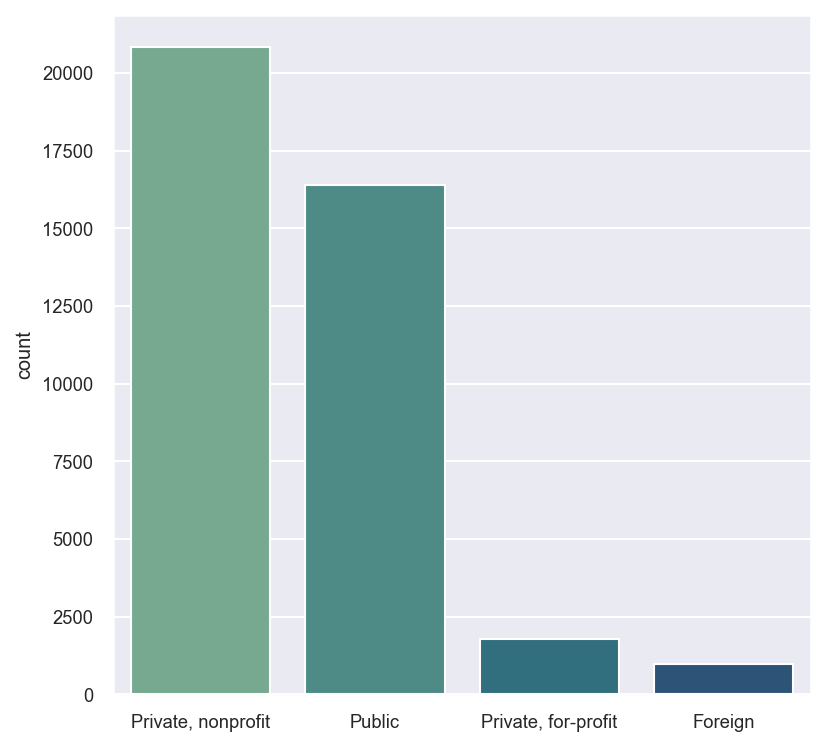

In [216]:
# viewing institution control by the numbers

plt.figure(figsize=(6, 6))
sns.set(font_scale = .8)

sns.countplot(
    train_imputed["institution_control"],
    order = train_imputed["institution_control"].value_counts().index,
    palette="crest")

plt.xlabel(None)
plt.show()

In [ ]:
# observations 
# private - non for profit wins out with most records in the training dataset
# where foreign is the least number of observations

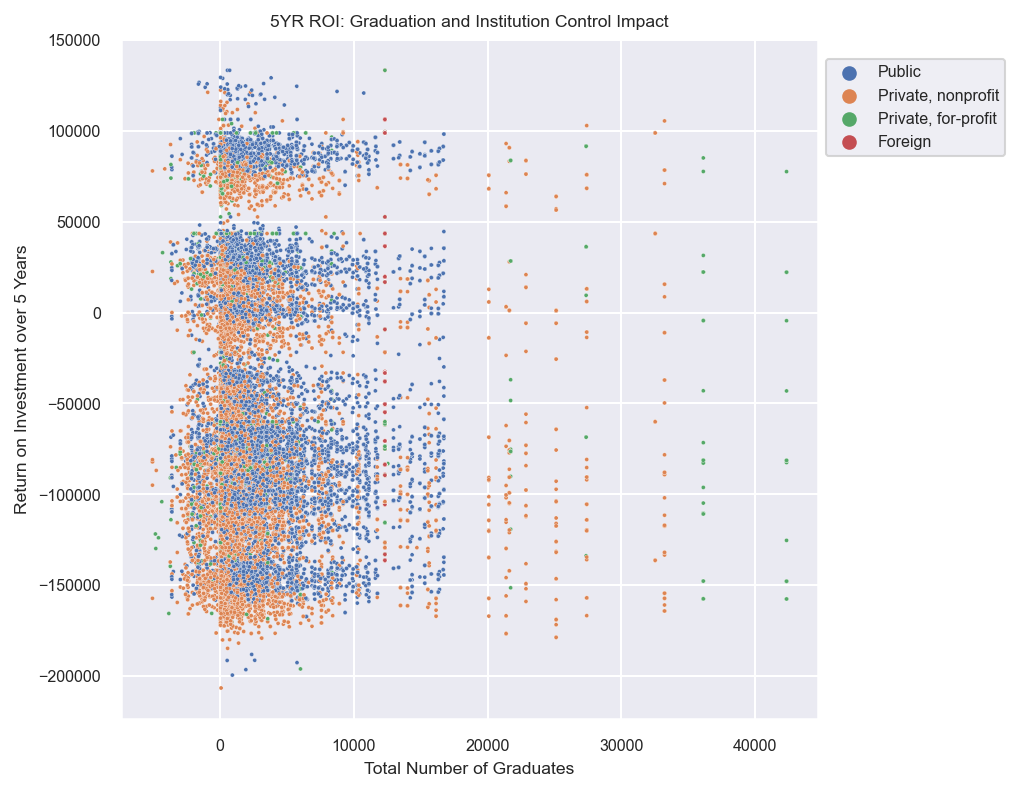

In [217]:
# plotting institution control type by 5_year ROI

plt.figure(figsize = (6, 6))
sns.set(font_scale = 0.7)

g = sns.scatterplot( 
    x = train_imputed["graduate_number"],
    y = train_imputed["roi_5yr"],
    data = train_imputed,
    hue = train_imputed["institution_control"],
    s = 4
)

g.legend(loc='center left', bbox_to_anchor=(1, 0.9), ncol=1)
plt.title("5YR ROI: Graduation and Institution Control Impact")
plt.xlabel("Total Number of Graduates")
plt.ylabel("Return on Investment over 5 Years")
plt.show()

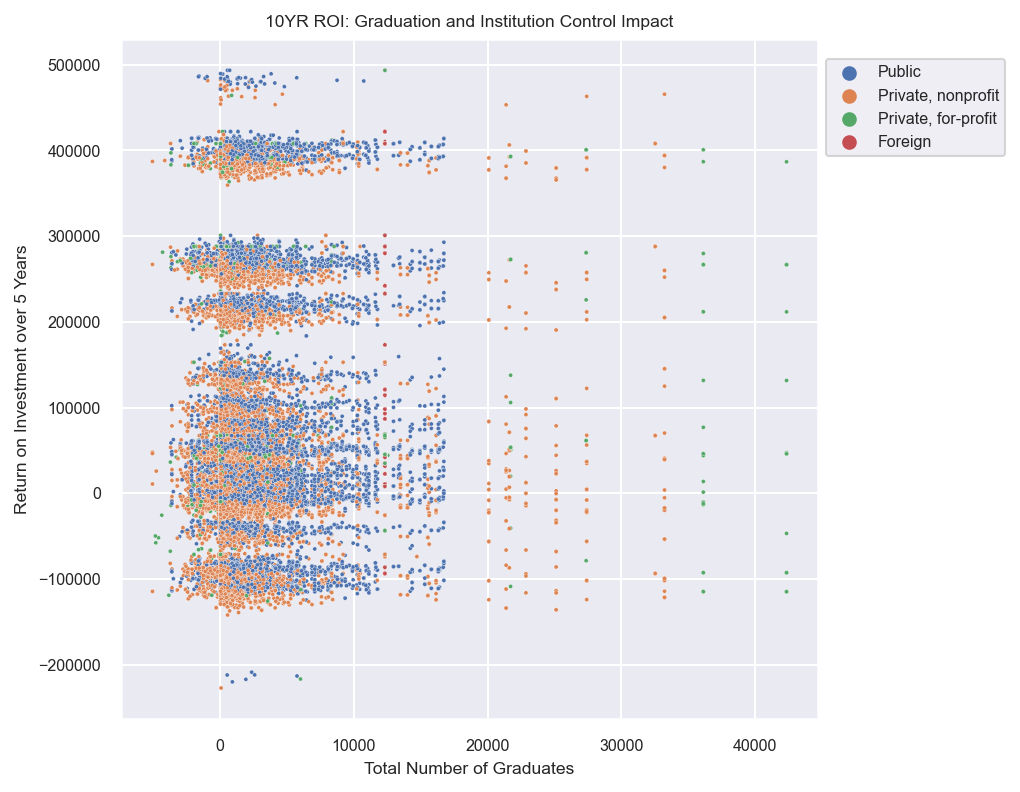

In [218]:
# plotting institution control type by 10_year ROI

plt.figure(figsize = (6, 6))
sns.set(font_scale = 0.7)

# data = train_imputed[train_imputed["graduate_number"] > 0]

g = sns.scatterplot( 
    x = train_imputed["graduate_number"],
    y = train_imputed["roi_10yr"],
    data = train_imputed[train_imputed["graduate_number"] > 0],
    hue = train_imputed["institution_control"],
    s = 4
)

g.legend(loc='center left', bbox_to_anchor=(1, 0.9), ncol=1)
plt.title("10YR ROI: Graduation and Institution Control Impact")
plt.xlabel("Total Number of Graduates")
plt.ylabel("Return on Investment over 5 Years")
plt.show()

In [219]:
train_imputed["major_category"].unique().tolist()

['English Language, Literature, and Composition',
 'Communications',
 'Fine Arts',
 'Business',
 'Biology and Life Sciences',
 'Medical and Health Sciences and Services',
 'Education Administration and Teaching',
 'Interdisciplinary and Multi-Disciplinary Studies (General)',
 'Linguistics and Foreign Languages',
 'Liberal Arts and Humanities',
 'Social Sciences',
 'Physical Fitness, Parks, Recreation, and Leisure',
 'Mathematics and Statistics',
 'Communication Technologies',
 'Computer and Information Sciences',
 'Public Affairs, Policy, and Social Work',
 'Law',
 'Criminal Justice and Fire Protection',
 'History',
 'Engineering',
 'Theology and Religious Vocations',
 'Psychology',
 'Environment and Natural Resources',
 'Philosophy and Religious Studies',
 'Engineering Technologies',
 'Physical Sciences',
 'Electrical and Mechanic Repairs and Technologies',
 'Area, Ethnic, and Civilization Studies',
 'Agriculture',
 'Military Technologies',
 'Cosmetology Services and Culinary Arts',
 

In [220]:
# 5YR/major average capture

majors = train_imputed["major_category"].unique().tolist()

pub_container = []
pri_profit_container = []
pri_nonprofit_container = []
forein_container = []

for major in majors:
    
    pub_values = train_imputed[(train_imputed["institution_control"] == "Public") & (train_imputed["major_category"] == major)]["roi_5yr"].values
    pri_profit_values = train_imputed[(train_imputed["institution_control"] == "Private, for-profit") & (train_imputed["major_category"] == major)]["roi_5yr"].values
    pri_nonprofit_values = train_imputed[(train_imputed["institution_control"] == "Private, nonprofit") & (train_imputed["major_category"] == major)]["roi_5yr"].values
    foreign_values = train_imputed[(train_imputed["institution_control"] == "Foreign") & (train_imputed["major_category"] == major)]["roi_5yr"].values

    # extend values
    pub_container.extend(pub_values)
    pri_profit_container.extend(pri_profit_values)
    pri_nonprofit_container.extend(pri_nonprofit_values)
    forein_container.extend(foreign_values)

print(f'length: {len(pub_container)}')
print(f'length: {len(pri_profit_container)}')
print(f'length: {len(pri_nonprofit_container)}')
print(f'length: {len(forein_container)}')

length: 16389
length: 1786
length: 20834
length: 986


In [221]:
# ANOVA hypothesis test for: institution control

f_statistic, p_value = stats.f_oneway(
    pub_container,
    pri_profit_container,
    pri_nonprofit_container,
    forein_container
    )

alpha = 0.05

# comparing the p_value to alpha
print(f'f statistic = {f_statistic.round(5)}')
print(f'p value = {p_value.round(5)}')
print("-----------------")

if p_value < alpha:
    print('We reject the null hypothesis. Means are different across the groups.')
else:
    print('We fail to reject the null hypothesis. Means are similar across the groups.')

f statistic = 404.30763
p value = 0.0
-----------------
We reject the null hypothesis. Means are different across the groups.


In [222]:
# 10yr/major average capture

majors = train_imputed["major_category"].unique().tolist()

pub_container = []
pri_profit_container = []
pri_nonprofit_container = []
forein_container = []

for major in majors:
    pub_mean = train_imputed[(train_imputed["institution_control"] == "Public") & (train_imputed["major_category"] == major)]["roi_10yr"].values
    pri_profit_mean = train_imputed[(train_imputed["institution_control"] == "Private, for-profit") & (train_imputed["major_category"] == major)]["roi_10yr"].values
    pri_nonprofit_mean = train_imputed[(train_imputed["institution_control"] == "Private, nonprofit") & (train_imputed["major_category"] == major)]["roi_10yr"].values
    foreign_mean = train_imputed[(train_imputed["institution_control"] == "Foreign") & (train_imputed["major_category"] == major)]["roi_10yr"].values

    # extend values
    pub_container.extend(pub_mean)
    pri_profit_container.extend(pri_profit_mean)
    pri_nonprofit_container.extend(pri_nonprofit_mean)
    forein_container.extend(foreign_mean)

print(f'length: {len(pub_container)}')
print(f'length: {len(pri_profit_container)}')
print(f'length: {len(pri_nonprofit_container)}')
print(f'length: {len(forein_container)}')

length: 16389
length: 1786
length: 20834
length: 986


In [223]:
# ANOVA hypothesis test for: institution control

f_statistic, p_value = stats.f_oneway(
    pub_container,
    pri_profit_container,
    pri_nonprofit_container,
    forein_container
    )

alpha = 0.05

# comparing the p_value to alpha
print(f'f statistic = {f_statistic.round(5)}')
print(f'p value = {p_value.round(5)}')
print("-----------------")

if p_value < alpha:
    print('We reject the null hypothesis. Means are different across the groups.')
else:
    print('We fail to reject the null hypothesis. Means are similar across the groups.')

f statistic = 265.76735
p value = 0.0
-----------------
We reject the null hypothesis. Means are different across the groups.


``observations:``

A college's institutional control is statistically significant in potentially predicting a student's 5 and 10 year ROI

In [225]:
train_imputed[train_imputed["graduate_number"] > 0.0]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39995 entries, 25530 to 63722
Data columns (total 80 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   college_name                                      39995 non-null  object 
 1   institution_control                               39995 non-null  object 
 2   zip_code                                          39995 non-null  object 
 3   share_entering_students_first_ft                  39995 non-null  float64
 4   share_of_part_time                                39995 non-null  float64
 5   required_score                                    39995 non-null  float64
 6   major_name                                        39995 non-null  object 
 7   online_only                                       39995 non-null  float64
 8   graduate_number                                   39995 non-null  float64
 9   deg_percent_a

In [ ]:
# what about number of graduates?



pd.qcut(
    train_imputed["graduate_number"],
    q = 4).unique()

[(3559.0, 42336.0], (-5053.535, 281.0], (1098.0, 3559.0], (281.0, 1098.0]]
Categories (4, interval[float64, right]): [(-5053.535, 281.0] < (281.0, 1098.0] < (1098.0, 3559.0] < (3559.0, 42336.0]]